# <span style="color:orange">I. Import Required Libraries</span>


In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from collections import Counter
import contractions
from nrclex import NRCLex
from textblob import TextBlob
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Spacy
import spacy
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

# Word Cloud
from wordcloud import WordCloud

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Importing required libraries
from imblearn.under_sampling import RandomUnderSampler

# <span style="color:orange">II. Load Dataset</span>

In [2]:
# Read positive reviews
with open('Datasets/positive-reviews.txt', 'r', encoding='utf-8') as f:
    positive_reviews = f.readlines()

# Read negative reviews
with open('Datasets/negative-reviews.txt', 'r', encoding='utf-8') as f:
    negative_reviews = f.readlines()

In [3]:
positive_reviews[:10]

['Size, Size, ans Size.\n',
 'Excellent quality, speedy printing, low cost\n',
 'Cheap, good quality, small size\n',
 'Attractive design, satisfying features, the backlight!\n',
 'Pretty much has every feature you could possibly need, great look\n',
 'Ease of use, small size and reliability\n',
 'cheap,good print quality\n',
 'takes clear shots\n',
 'Small, Light, Stylish, backlight\n',
 'Absolutely Outstanding Photo Printing Results.  Easy to Use.\n']

In [4]:
negative_reviews[:10]

['Image quality not as good as some other brands, cheap feel to body.\n',
 'nothing\n',
 'Black text could be better, ink runs out kind of fast\n',
 "The thing won't work\n",
 'Display grainy, small keypad for text messaging, poor vibrate function\n',
 "Unfriendly user interface, not alot of features, Qwest's service`\n",
 'Only Serial Connection, No Optical Zoom, Bulky\n',
 'noise, the fact that it broke\n',
 'flip button difficult to press at times\n',
 'Voice quality patchy, Web service very patchy\n']

In [5]:
# Combine positive and negative review into one Dataset 
data = pd.DataFrame({'review_text': positive_reviews + negative_reviews,
                     'label': [1] * len(positive_reviews) + [0] * len(negative_reviews)})

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

data

,review_text,label
0,Many Many features\n,1
1,"Slow zoom response, somewhat long start up tim...",0
2,"Palm is a good OS, just not on this product.\n",1
3,marginal image quality; limited storage; inade...,0
4,Paper feeds three or four sheets at a time. A ...,0
...,...,...
39995,Amazing price! Great performance!\n,1
39996,no storage\n,0
39997,"still not as good as a real photo, still runs ...",0
39998,"goes thru batteries like crazy, battery door i...",0


# <span style="color:orange">III. Explore Data Visualization (raw data)</span>

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  40000 non-null  object
 1   label        40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


Label Distribution:
label
1    20000
0    20000
Name: count, dtype: int64


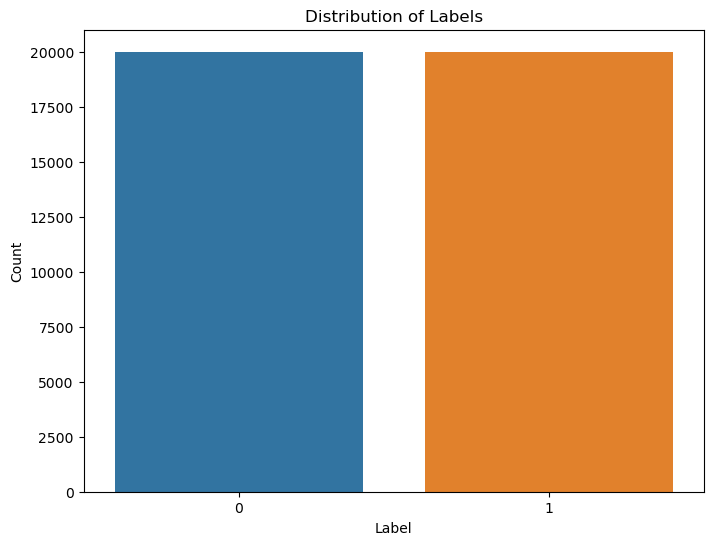

In [7]:
# Data Distribution
def plot_label_distribution(data):
    """
    Plots the distribution of labels in the dataset.
    
    Args:
    - data (DataFrame): The dataframe containing the label column.
    """
    label_distribution = data['label'].value_counts()
    print("Label Distribution:")
    print(label_distribution)

    # Plotting the distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Call the function with your DataFrame
plot_label_distribution(data)

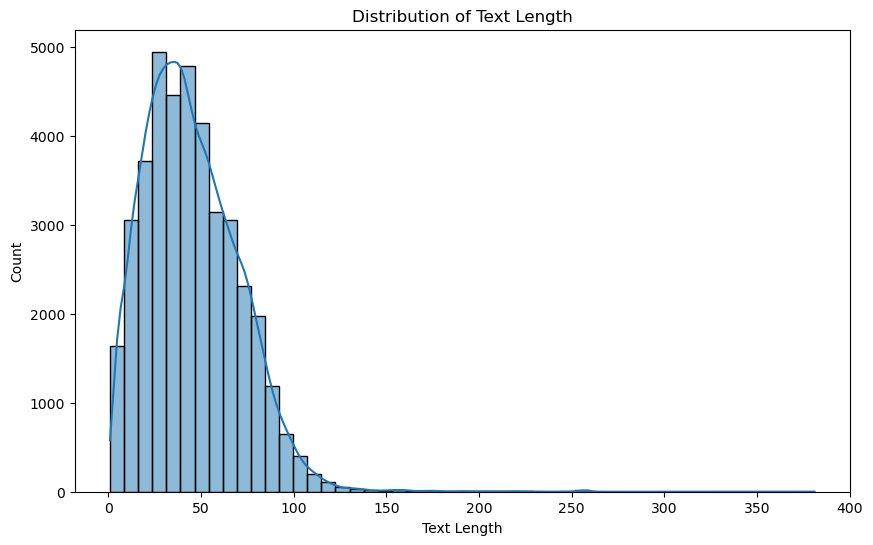

In [8]:
# Plotting text length distribution
def plot_text_length_distribution(data, text_column):
    """
    Plots the distribution of text length in the specified column of the dataset.
    
    Args:
    - data (DataFrame): The dataframe containing the text column.
    - text_column (str): The name of the text column to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[text_column].apply(len), bins=50, kde=True)
    plt.title('Distribution of Text Length')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

# Call the function with your DataFrame and text column
plot_text_length_distribution(data, 'review_text')

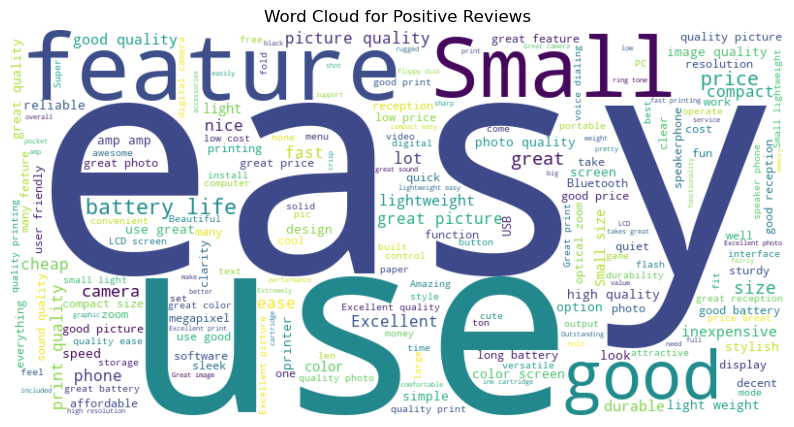

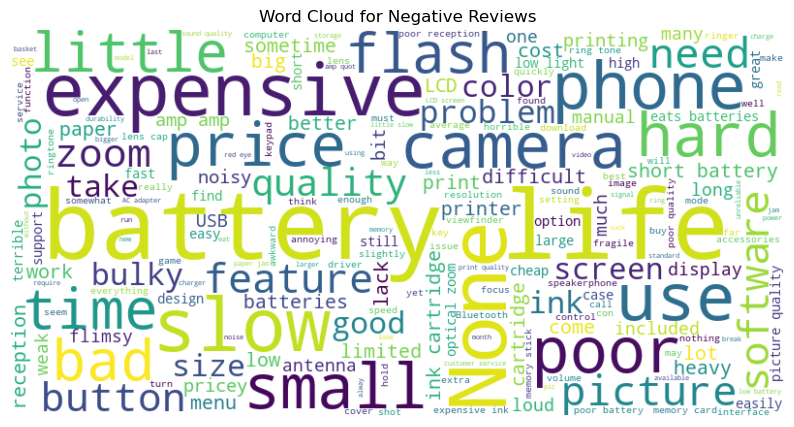

In [9]:
# Word Frequency Analysis
# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_wordclouds_for_sentiments(data, text_column, label_column, positive_label=1, negative_label=0):
    """
    Plots word clouds for positive and negative sentiment reviews.
    
    Args:
    - data (DataFrame): The dataframe containing the text and label columns.
    - text_column (str): The name of the column containing the text data.
    - label_column (str): The name of the column containing the labels.
    - positive_label (int): The value representing positive sentiment.
    - negative_label (int): The value representing negative sentiment.
    """
    # Extracting positive and negative reviews
    positive_reviews = ' '.join(data[data[label_column] == positive_label][text_column])
    negative_reviews = ' '.join(data[data[label_column] == negative_label][text_column])

    # Plotting word clouds for positive and negative reviews
    plot_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
    plot_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

# Call the function with your DataFrame and column names
plot_wordclouds_for_sentiments(data, 'review_text', 'label')

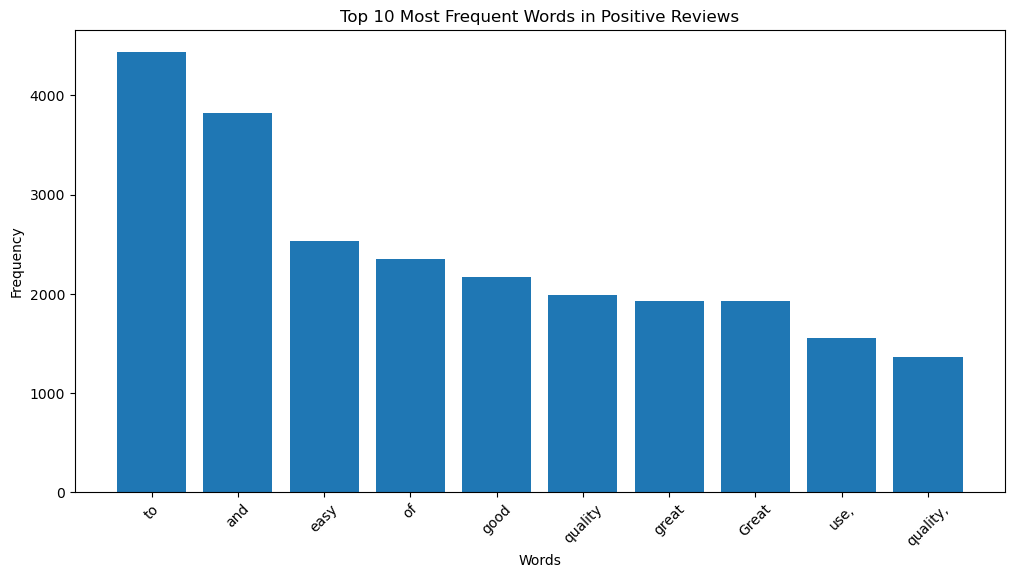

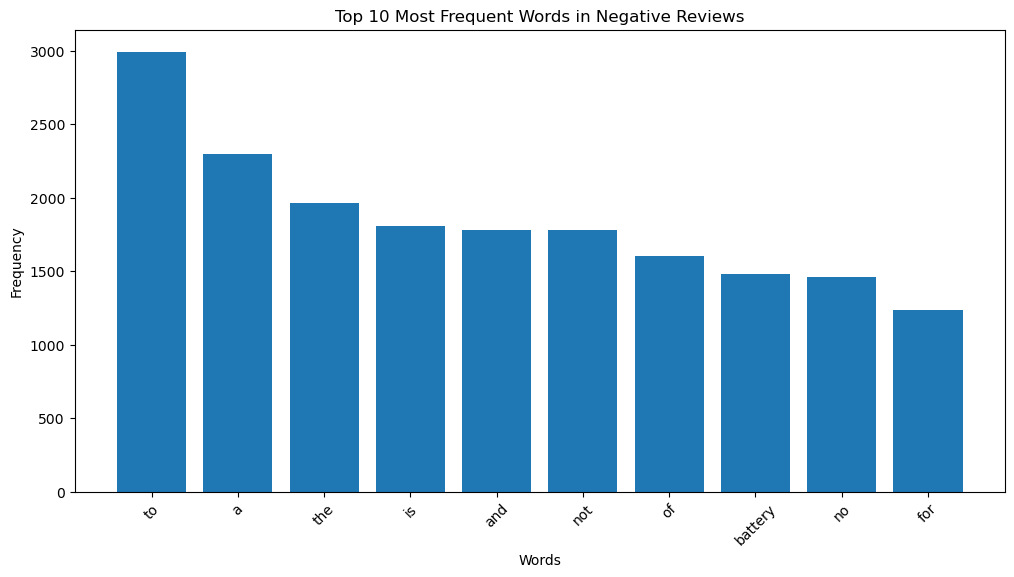

In [10]:
def plot_top_words_frequency(tokens, title):
    word_freq = Counter(tokens)
    top_words, top_freq = zip(*word_freq.most_common(10))
    
    plt.figure(figsize=(12, 6))
    plt.bar(top_words, top_freq)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Split the reviews
positive_tokens = ' '.join(data[data['label'] == 1]['review_text']).split()
negative_tokens = ' '.join(data[data['label'] == 0]['review_text']).split()

# Plot top 10 most frequent words in positive reviews
plot_top_words_frequency(positive_tokens, 'Top 10 Most Frequent Words in Positive Reviews')

# Plot top 10 most frequent words in negative reviews
plot_top_words_frequency(negative_tokens, 'Top 10 Most Frequent Words in Negative Reviews')

# <span style="color:orange">IV. Data Preprocessing</span>

## <span style="color:blue">1. Remove Irrelevant Data</span>
Remove missing values, garbage values, duplicate values, and non-necessary values


In [11]:
# Check missing values
data.isnull().sum()

review_text    0
label          0
dtype: int64

In [12]:
# Check duplicated values
data.duplicated().sum()

3448

In [13]:
# Remove duplicated values
data = pd.DataFrame(data.drop_duplicates())
data.duplicated().sum()

0

In [14]:
# Remove \n 
data['review_text'] = data['review_text'].str.strip()

In [15]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'N/A']
none_rows

,review_text,label
3635,N/A,0
35808,N/A,1


In [16]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'n/a']
none_rows

,review_text,label
152,n/a,0


In [17]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'None']
none_rows

,review_text,label
11,None,0
218,None,1


In [18]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'none']
none_rows

,review_text,label
95,none,0
153,none,1


In [19]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'nothing']
none_rows

,review_text,label
255,nothing,0


In [20]:
# Check if there are None rows
none_rows = data[data['review_text'] == 'Nothing']
none_rows

,review_text,label
421,Nothing,1
22157,Nothing,0


In [21]:
# Convert 'N/A' and 'n/a' to NaN
data['review_text'] = data['review_text'].replace(['N/A', 'n/a','None','none','Nothing','nothing','N-O-I-S-E'], np.nan)

# Drop rows where 'review_text' is NaN
data = pd.DataFrame(data.dropna(subset=['review_text']))

# Print the updated DataFrame
data

,review_text,label
0,Many Many features,1
1,"Slow zoom response, somewhat long start up tim...",0
2,"Palm is a good OS, just not on this product.",1
3,marginal image quality; limited storage; inade...,0
4,Paper feeds three or four sheets at a time. A ...,0
...,...,...
39994,"Fast, high quality, reliable",1
39995,Amazing price! Great performance!,1
39997,"still not as good as a real photo, still runs ...",0
39998,"goes thru batteries like crazy, battery door i...",0


In [22]:
# Check for rows without alphabet characters in 'cleaned_review_text' column
no_alphabet_mask = ~data['review_text'].str.contains('[a-zA-Z]')

# Filter the DataFrame to keep rows without alphabet characters
data_no_alphabet = pd.DataFrame(data[no_alphabet_mask])

# Print the rows where 'cleaned_review_text' does not contain any alphabet characters
data_no_alphabet

,review_text,label
128,0,1
329,???,1
971,--,0
1370,?,0
1701,,0
2439,$$$,0
2586,?,1
3458,???,0
4223,$300,0
4512,.....,0


In [23]:
# Check for rows with alphabet characters in 'cleaned_review_text' column
contains_alphabet_mask = data['review_text'].str.contains('[a-zA-Z]')

# Filter the DataFrame to keep rows with alphabet characters
data = pd.DataFrame(data[contains_alphabet_mask])

# Print the filtered DataFrame
data

,review_text,label
0,Many Many features,1
1,"Slow zoom response, somewhat long start up tim...",0
2,"Palm is a good OS, just not on this product.",1
3,marginal image quality; limited storage; inade...,0
4,Paper feeds three or four sheets at a time. A ...,0
...,...,...
39994,"Fast, high quality, reliable",1
39995,Amazing price! Great performance!,1
39997,"still not as good as a real photo, still runs ...",0
39998,"goes thru batteries like crazy, battery door i...",0


## <span style="color:blue">2. Text Preprocessing</span>
Define a function for text preprocessing and store the results in a new column called **'cleaned_review_text'**.

1. **Remove extra spaces**:
   - Using regular expressions, eliminate any redundant spaces within the text.

2. **Convert text to lowercase**:
   - Convert all characters in the text to lowercase to ensure uniformity.

3. **Expand contractions**:
   - Utilize the `contractions.fix()` function to expand contracted words in the text.

4. **Replace repetitions of punctuation with a single punctuation**:
   - Employ regular expressions to replace consecutive occurrences of punctuation with a single instance.

5. **Remove punctuation (except '!') and numbers**:
   - Use regular expressions to eliminate all punctuation marks and numerical digits from the text, with the exception of the exclamation mark '!'.

6. **Remove emojis**:
   - Utilize either regular expressions or a library to remove emojis from the text.

7. **Tokenize text**:
   - Segment the text into individual words or tokens using a tokenizer.

8. **Remove stop words except 'no' and 'not'**:
   - Exclude common stop words, which are words that typically do not carry significant meaning, from the text. However, retain the words 'no' and 'not' as they can alter the meaning of a sentence.

9. **Lemmatization**:
   - Apply lemmatization to reduce each word to its base or dictionary form, considering the context oent text after preprocessing.



In [24]:
def text_preprocessing(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Replace repetitions of punctuation with a single punctuation mark
    text = re.sub(r'(\W)\1+', r'\1', text)

    # Remove punctuation(except !) and numbers
    text = re.sub(r'[^a-zA-Z!]+', ' ', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Tokenize text using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words except 'no' and 'not' - SpaCy has its own stop words list
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop or token in {'no', 'not'}]

    # Lemmatization - SpaCy performs lemmatization automatically
    tokens = [token.lemma_ for token in doc]

    # Return Join tokens back into text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply the function to the 'review_text' column and store the results in a new column 'cleaned_review_text'
data['cleaned_review_text'] = data['review_text'].apply(text_preprocessing)

data

,review_text,label,cleaned_review_text
0,Many Many features,1,many many feature
1,"Slow zoom response, somewhat long start up tim...",0,slow zoom response somewhat long start up time...
2,"Palm is a good OS, just not on this product.",1,palm be a good os just not on this product
3,marginal image quality; limited storage; inade...,0,marginal image quality limit storage inadequat...
4,Paper feeds three or four sheets at a time. A ...,0,paper feed three or four sheet at a time a car...
...,...,...,...
39994,"Fast, high quality, reliable",1,fast high quality reliable
39995,Amazing price! Great performance!,1,amazing price ! great performance !
39997,"still not as good as a real photo, still runs ...",0,still not as good as a real photo still run ou...
39998,"goes thru batteries like crazy, battery door i...",0,go thru battery like crazy battery door be weak


## <span style="color:blue">3. Feature Extraction</span>

Feature extraction is a process in which relevant information is extracted from raw data to create new features that are more informative and suitable for machine learning algorithms. This step is crucial for improving the performance of models by reducing dimensionality, removing noise, and highlighting important patterns in the data.


### <span style="color:green">a. Count of Positive and Negative Words in Review Text</span>
This analysis provides a breakdown of the number of positive and negative words found in the review text. Positive and negative sentiments are quantified to gain insights into the overall tone of the reviews.

In [25]:
def count_positive_words(cleaned_review_text):
    positive_words = set()
    with open('Datasets/positive-words.txt', 'r', encoding='latin-1') as f:
        positive_words = set(f.read().splitlines())
    words = cleaned_review_text.split()
    count = sum(1 for word in words if word in positive_words)
    return count

def count_negative_words(cleaned_review_text):
    negative_words = set()
    with open('Datasets/negative-words.txt', 'r', encoding='latin-1') as f:
        negative_words = set(f.read().splitlines())
    words = cleaned_review_text.split()
    count = sum(1 for word in words if word in negative_words)
    return count

In [26]:
# Apply function count_positive_words and count_negative_words to cleaned_review_text
data['count_positive_words'] = data['cleaned_review_text'].apply(count_positive_words)
data['count_negative_words'] = data['cleaned_review_text'].apply(count_negative_words)

In [27]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words
0,Many Many features,1,many many feature,0,0
1,"Slow zoom response, somewhat long start up tim...",0,slow zoom response somewhat long start up time...,0,2
2,"Palm is a good OS, just not on this product.",1,palm be a good os just not on this product,1,0
3,marginal image quality; limited storage; inade...,0,marginal image quality limit storage inadequat...,1,3
4,Paper feeds three or four sheets at a time. A ...,0,paper feed three or four sheet at a time a car...,0,1
5,"Flash, No battery indicator, No Case.",0,flash no battery indicator no case,0,0
6,price and ink prices,0,price and ink price,0,0
7,expensive up keep,0,expensive up keep,0,1
8,"The 3120 looks better, but u can put the 3120 ...",0,the look well but you can put the face plate o...,1,0
9,"Ease of use, software installed without a hitch.",1,ease of use software instal without a hitch,1,0


### <span style="color:green">b. Check for Presence of 'no' or 'not' in Review Text</span>
This analysis examines whether the review text includes the words 'no' or 'not'. Identifying the presence of these words can be crucial for understanding negation in the sentiment expressed within the reviews.
views.


In [28]:
def contain_no(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_no = int('no' in tokens)
    return contain_no

def contain_not(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_not = int('not' in tokens)
    return contain_not

In [29]:
# Apply function contains_no and contains_not to cleaned_review_text
data['contain_no'] = data['cleaned_review_text'].apply(contain_no)
data['contain_not'] = data['cleaned_review_text'].apply(contain_not)

In [30]:
data.tail(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not
39987,"Too small, it is hard to push a button it is s...",0,too small it be hard to push a button it be so...,0,1,0,0
39988,"pretty small, has games, durable.",1,pretty small have game durable,2,0,0,0
39989,Accompanying software is too simple. All you ...,0,accompany software be too simple all you need ...,0,0,0,0
39990,Takes forever to snap a shot,0,take forever to snap a shot,0,0,0,0
39992,"Camera works, even in dim light; easy-to-read ...",1,camera work even in dim light easy to read lcd...,2,1,0,0
39994,"Fast, high quality, reliable",1,fast high quality reliable,2,0,0,0
39995,Amazing price! Great performance!,1,amazing price ! great performance !,2,0,0,0
39997,"still not as good as a real photo, still runs ...",0,still not as good as a real photo still run ou...,1,0,0,1
39998,"goes thru batteries like crazy, battery door i...",0,go thru battery like crazy battery door be weak,1,2,0,0
39999,cheap in price,1,cheap in price,0,1,0,0


### <span style="color:green">c. Check for Presence of '!' in Review Text</span>
This analysis looks for the presence of the exclamation mark '!' within the review text. The presence of '!' can indicate emphasis or heightened emotion in the expressed sentiments.

In [31]:
def contain_exclamation(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_exclamation = int('!' in tokens)
    return contain_exclamation

In [32]:
# Apply function contain_exclamation to cleaned_review_text
data['contain_exclamation'] = data['cleaned_review_text'].apply(contain_exclamation)

In [33]:
data.tail(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation
39987,"Too small, it is hard to push a button it is s...",0,too small it be hard to push a button it be so...,0,1,0,0,0
39988,"pretty small, has games, durable.",1,pretty small have game durable,2,0,0,0,0
39989,Accompanying software is too simple. All you ...,0,accompany software be too simple all you need ...,0,0,0,0,0
39990,Takes forever to snap a shot,0,take forever to snap a shot,0,0,0,0,0
39992,"Camera works, even in dim light; easy-to-read ...",1,camera work even in dim light easy to read lcd...,2,1,0,0,0
39994,"Fast, high quality, reliable",1,fast high quality reliable,2,0,0,0,0
39995,Amazing price! Great performance!,1,amazing price ! great performance !,2,0,0,0,1
39997,"still not as good as a real photo, still runs ...",0,still not as good as a real photo still run ou...,1,0,0,1,0
39998,"goes thru batteries like crazy, battery door i...",0,go thru battery like crazy battery door be weak,1,2,0,0,0
39999,cheap in price,1,cheap in price,0,1,0,0,0


### <span style="color:green">d. Log of Review Text Length</span>
This analysis calculates the logarithm of the length of the review text. Taking the logarithm of the length can help normalize the data and highlight differences in text length more effectively.


In [34]:
def log_review_length(review_text):
    review_length = len(review_text)
    if review_length == 0:
        return 0  # Return 0 if the review length is 0
    log_length = math.log(review_length)
    return log_length

In [35]:
# Apply function log_review_length to cleaned_review_text
data['log_review_length'] = data['cleaned_review_text'].apply(log_review_length)

In [36]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length
0,Many Many features,1,many many feature,0,0,0,0,0,2.833213
1,"Slow zoom response, somewhat long start up tim...",0,slow zoom response somewhat long start up time...,0,2,0,0,0,4.127134
2,"Palm is a good OS, just not on this product.",1,palm be a good os just not on this product,1,0,0,1,0,3.737670
3,marginal image quality; limited storage; inade...,0,marginal image quality limit storage inadequat...,1,3,0,0,0,4.143135
4,Paper feeds three or four sheets at a time. A ...,0,paper feed three or four sheet at a time a car...,0,1,1,0,0,4.219508
5,"Flash, No battery indicator, No Case.",0,flash no battery indicator no case,0,0,1,0,0,3.526361
6,price and ink prices,0,price and ink price,0,0,0,0,0,2.944439
7,expensive up keep,0,expensive up keep,0,1,0,0,0,2.833213
8,"The 3120 looks better, but u can put the 3120 ...",0,the look well but you can put the face plate o...,1,0,0,0,0,3.951244
9,"Ease of use, software installed without a hitch.",1,ease of use software instal without a hitch,1,0,0,0,0,3.761200


### <span style="color:green">e. Emotion Label Based on Review Text</span>
This analysis assigns an emotion label to each review text based on the predominant emotion expressed. Emotions such as joy, sadness, anger, surprise, and others may be identified using sentiment analysis techniques, helping to categorize the overall emotional tone of the reviews.


In [37]:
def get_emotion_label(phrase):
    # Tokenize the phrase
    tokens = phrase.split()

    # Define emotion word list
    emotion_words = []

    for i in range(len(tokens)):
      # Call NRCLex constructor
      emotion = NRCLex(tokens[i])
      # Get affect_dict
      affect_dict = emotion.affect_dict
      # Extract emotion words from affect_dict values
      for sublist in affect_dict.values():
        emotion_words.extend(sublist)

    # Define positive and negative emotion groups
    positive_emotions = ['anticipation', 'trust', 'positive', 'joy', 'surprise']
    negative_emotions = ['fear', 'anger', 'negative', 'sadness', 'disgust']

    # Count occurrences of positive and negative words
    positive_count = sum(emotion_words.count(emotion) for emotion in positive_emotions)
    negative_count = sum(emotion_words.count(emotion) for emotion in negative_emotions)

    # Determine sentiment label based on counts
    if positive_count > negative_count:
        return 1
    elif positive_count < negative_count:
        return 0
    else:
        return 2

# Sample usage
phrase = "This movie is great and wonderful, but it made me sad."
emotion_label = get_emotion_label(phrase)
print("Emotion label:", emotion_label)

Emotion label: 1


In [38]:
# Apply function get_emotion_label to cleaned_review_text
data['emotion_label'] = data['cleaned_review_text'].apply(get_emotion_label)

In [39]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label
0,Many Many features,1,many many feature,0,0,0,0,0,2.833213,1
1,"Slow zoom response, somewhat long start up tim...",0,slow zoom response somewhat long start up time...,0,2,0,0,0,4.127134,1
2,"Palm is a good OS, just not on this product.",1,palm be a good os just not on this product,1,0,0,1,0,3.737670,1
3,marginal image quality; limited storage; inade...,0,marginal image quality limit storage inadequat...,1,3,0,0,0,4.143135,0
4,Paper feeds three or four sheets at a time. A ...,0,paper feed three or four sheet at a time a car...,0,1,1,0,0,4.219508,0
5,"Flash, No battery indicator, No Case.",0,flash no battery indicator no case,0,0,1,0,0,3.526361,0
6,price and ink prices,0,price and ink price,0,0,0,0,0,2.944439,2
7,expensive up keep,0,expensive up keep,0,1,0,0,0,2.833213,2
8,"The 3120 looks better, but u can put the 3120 ...",0,the look well but you can put the face plate o...,1,0,0,0,0,3.951244,2
9,"Ease of use, software installed without a hitch.",1,ease of use software instal without a hitch,1,0,0,0,0,3.761200,1


### <span style="color:green">f. Sentiment Score Calculation</span>
This analysis computes the sentiment score for each review text. The sentiment score quantifies the overall sentiment expressed in the review, typically ranging from negative to positive values.


In [40]:
def calculate_sentiment_score(phrase):
    # Create a TextBlob object
    blob = TextBlob(phrase)

    # Get the sentiment score
    sentiment_score = blob.sentiment.polarity

    return sentiment_score

# Sample usage
phrase = "This movie is great and wonderful, but it made me sad."
sentiment_score = calculate_sentiment_score(phrase)
print("Sentiment score:", sentiment_score)

Sentiment score: 0.43333333333333335


In [41]:
# Apply function calculate_sentiment_score to cleaned_review_text
data['sentiment_score'] = data['cleaned_review_text'].apply(calculate_sentiment_score)

In [42]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
0,Many Many features,1,many many feature,0,0,0,0,0,2.833213,1,0.500000
1,"Slow zoom response, somewhat long start up tim...",0,slow zoom response somewhat long start up time...,0,2,0,0,0,4.127134,1,-0.216667
2,"Palm is a good OS, just not on this product.",1,palm be a good os just not on this product,1,0,0,1,0,3.737670,1,0.700000
3,marginal image quality; limited storage; inade...,0,marginal image quality limit storage inadequat...,1,3,0,0,0,4.143135,0,0.000000
4,Paper feeds three or four sheets at a time. A ...,0,paper feed three or four sheet at a time a car...,0,1,1,0,0,4.219508,0,0.000000
5,"Flash, No battery indicator, No Case.",0,flash no battery indicator no case,0,0,1,0,0,3.526361,0,0.000000
6,price and ink prices,0,price and ink price,0,0,0,0,0,2.944439,2,0.000000
7,expensive up keep,0,expensive up keep,0,1,0,0,0,2.833213,2,-0.500000
8,"The 3120 looks better, but u can put the 3120 ...",0,the look well but you can put the face plate o...,1,0,0,0,0,3.951244,2,0.000000
9,"Ease of use, software installed without a hitch.",1,ease of use software instal without a hitch,1,0,0,0,0,3.761200,1,0.000000


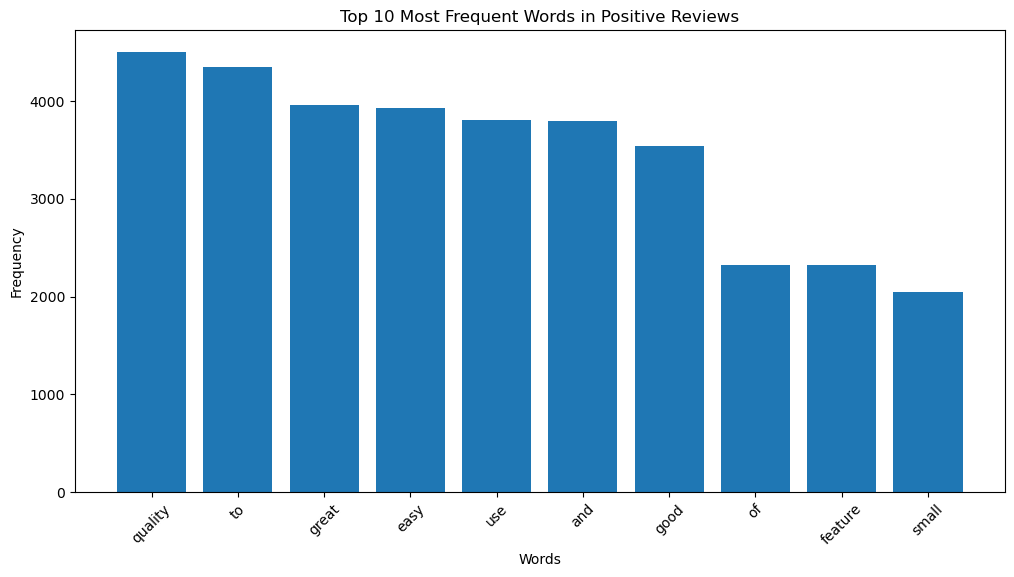

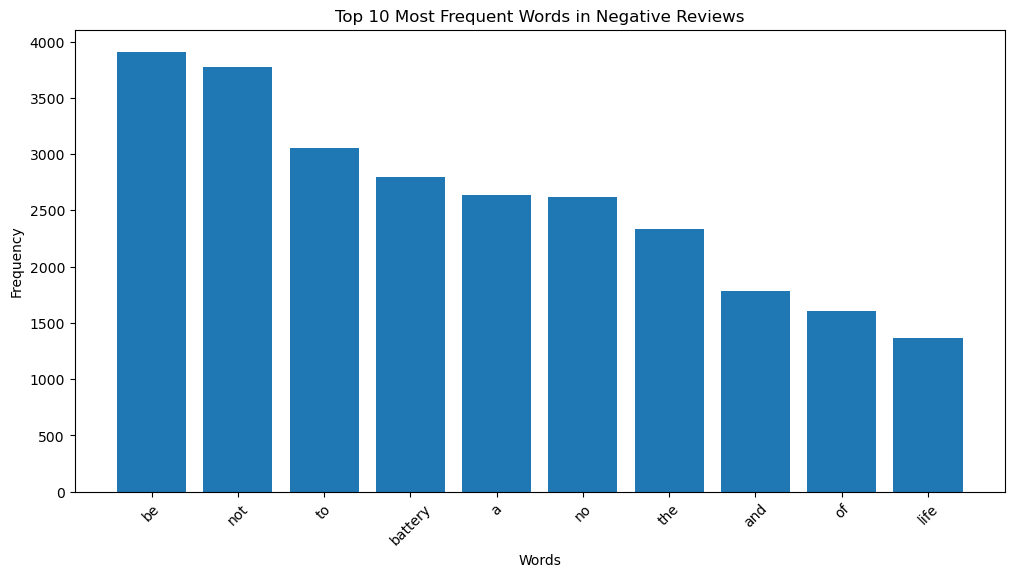

In [43]:
# Split the reviews
positive_tokens = ' '.join(data[data['label'] == 1]['cleaned_review_text']).split()
negative_tokens = ' '.join(data[data['label'] == 0]['cleaned_review_text']).split()

# Plot top 10 most frequent words in positive reviews
plot_top_words_frequency(positive_tokens, 'Top 10 Most Frequent Words in Positive Reviews')

# Plot top 10 most frequent words in negative reviews
plot_top_words_frequency(negative_tokens, 'Top 10 Most Frequent Words in Negative Reviews')

Label Distribution:
label
1    18704
0    17806
Name: count, dtype: int64


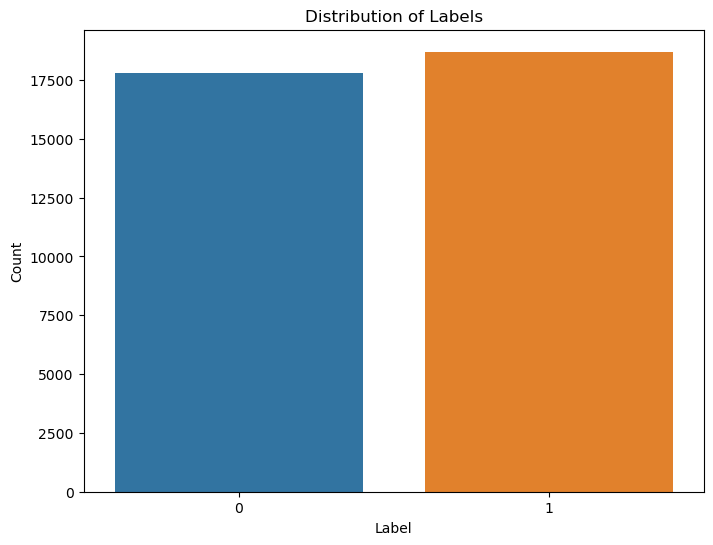

In [44]:
# Plot label distribution
plot_label_distribution(data)

## <span style="color:blue">3. Data Preparation</span>

Data preparation splitting the dataset into training and test sets, typically using 80% of the data for training and 20% for testing.

**Stratified** sampling is a sampling method in which the population is divided into subgroups or strata, and a sample is taken from each stratum. This method is used when the population includes different subgroups that are important to the study, and it is important to ensure that each subgroup is represented in the sample. The goal of stratified sampling is to ensure that the sample is representative of the entire population by ensuring that each subgroup is adequately represented.

In the context of train_test_split, stratified sampling can be useful when dealing with imbalanced datasets to ensure that the training and test datasets have the same proportion of class labels as the input dataset.

In [198]:
# Splitting the data into features (X) and labels (y)
X = data.drop(columns=['review_text', 'label'])
y = data['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [199]:
# Combining X_test and y_test into a single dataframe
test_data = pd.concat([X_test, y_test], axis=1)
test_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
29708,underfeatured non standard battery,0,0,0,0,0,3.526361,0,0.000000,0
8566,expensive duh,0,1,0,0,0,2.564949,2,-0.400000,0
36398,startup loading take too long take awhile to f...,0,0,0,0,0,4.343805,1,-0.050000,0
37786,small lightweight belt clip be very handy,1,0,0,0,0,3.713572,0,0.265000,1
19837,cool look bluetooth global phone,1,0,0,0,0,3.465736,1,0.175000,1
...,...,...,...,...,...,...,...,...,...,...
27178,small lightweight easy to use with a headset a...,1,0,0,0,0,4.174387,0,0.091667,1
30435,accept quite large format paper and print use ...,0,0,0,0,0,4.189655,2,0.157143,1
1202,handy simple to use,1,0,0,0,0,2.944439,1,0.300000,1
2212,good,1,0,0,0,0,1.386294,1,0.700000,1


Label Distribution:
label
1    3741
0    3561
Name: count, dtype: int64


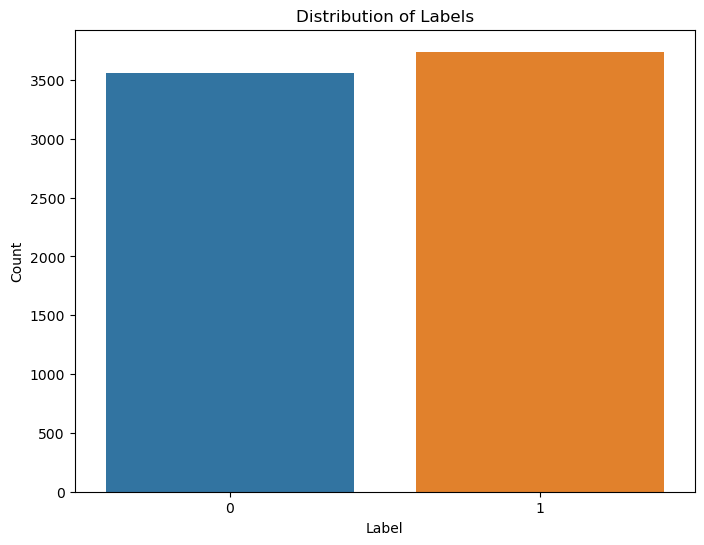

In [200]:
# Plot label distribution
plot_label_distribution(test_data)

In [201]:
# Combining X_train and y_train into a single dataframe
train_data = pd.concat([X_train, y_train], axis=1)
train_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
11405,aa battery run out too quickly hp do not provi...,0,0,0,1,0,4.077537,2,-0.166667,0
11308,small user friendly good clarity and dependabl...,5,0,0,0,1,4.343805,1,0.362500,1
18287,cheap price cheap black ink refill,0,2,0,0,0,3.526361,0,0.211111,1
39762,quiet usb,1,0,0,0,0,2.197225,2,0.000000,1
10193,waterproof ink quiet quality fast,2,0,0,0,0,3.496508,1,0.100000,1
...,...,...,...,...,...,...,...,...,...,...
20080,ease of use quality and quiet operation,2,0,0,0,0,3.663562,1,0.000000,1
20247,no optical viewfinder weak flash,0,1,1,0,0,3.465736,2,-0.375000,0
13177,compact size ease of use picture quality,2,0,0,0,0,3.688879,1,0.000000,1
11542,paper feed problem flimsy paper tray design li...,0,3,0,0,0,4.317488,0,0.000000,0


Label Distribution:
label
1    14963
0    14245
Name: count, dtype: int64


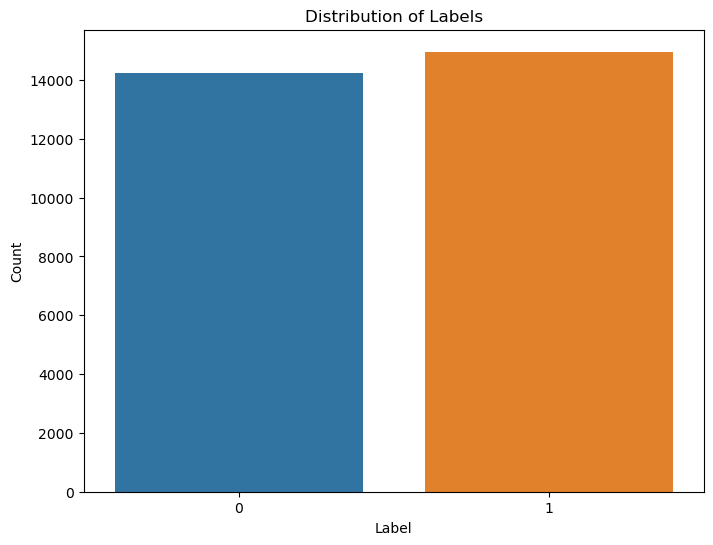

In [202]:
# Plot label distribution
plot_label_distribution(train_data)

## <span style="color:blue">4. Data Balancing</span>

**Data balancing** is a process used to address class **imbalance** in a dataset, where one class is significantly more prevalent than others. This imbalance can lead to biased model performance, with the majority class dominating predictions. Techniques such as **oversampling** the minority class, **undersampling** the majority class, or using synthetic data generation methods can help balance the dataset and improve the model's ability to generalize across all classes.

It's important to always split the dataset into training and testing sets before balancing the data. That way, it ensures that the test dataset is as unbiased as it can be and reflects a true evaluation for the models.



***RandomUnderSampler*** involves randomly selecting examples from the majority class and deleting them from the training dataset. In the random under-sampling, the majority class instances are discarded at random until a more balanced distribution is reached.

In [203]:
# Creating an instance of RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Balancing the training data using RandomUnderSampler
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

In [204]:
# Combining X_train and y_train into a single dataframe
train_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)
train_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
11405,aa battery run out too quickly hp do not provi...,0,0,0,1,0,4.077537,2,-0.166667,0
8008,slow color printing when you want good quality...,1,1,0,1,0,4.094345,1,0.200000,0
5467,slow and unreliable,0,2,0,0,0,2.944439,2,-0.300000,0
38746,no day time stamp on caller i d flimsy antenna,0,1,1,0,0,3.828641,1,0.000000,0
11067,not very dependable,1,0,0,1,0,2.944439,2,-0.100000,0
...,...,...,...,...,...,...,...,...,...,...
33385,fast very quiet incredible photo quality on ep...,4,0,0,0,0,4.543295,1,0.525000,1
31620,never a problem small size,0,1,0,0,0,3.258097,0,-0.250000,1
9762,could be use as a weapon in the battle of good...,1,1,0,0,0,3.988984,0,-0.150000,1
27254,small light weight easy to navigate clear voic...,3,0,0,0,0,4.204693,1,0.336667,1


Label Distribution:
label
0    14245
1    14245
Name: count, dtype: int64


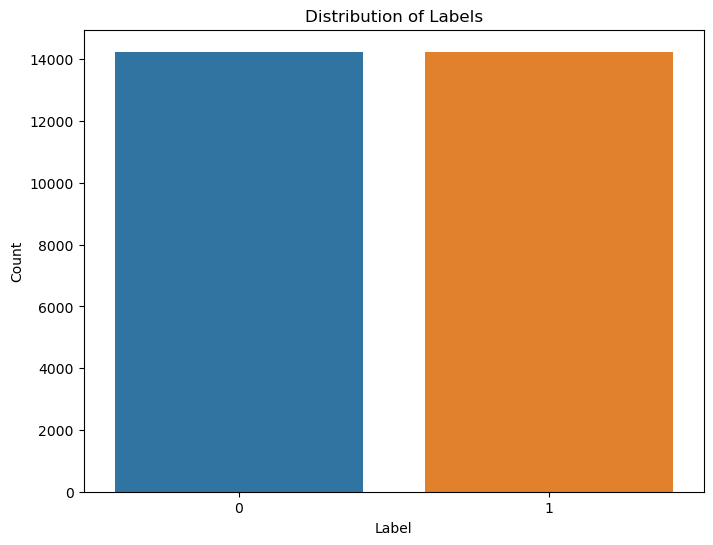

In [205]:
# Plot label distribution
plot_label_distribution(train_data)

## <span style="color:blue">5. Feature Scaling ( numerical features )</span>
***Feature scaling*** is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

***StandardScaler*** comes into play when the characteristics of the input dataset differ greatly between their ranges, or simply when they are measured in different units of measure. StandardScaler removes the mean and scales the data to the unit variance.

In [206]:
# assign variable names to the columns containing numerical data and text data
numerical_columns = ['count_positive_words', 'count_negative_words', 'contain_no', 'contain_not',
                     'contain_exclamation', 'log_review_length', 'emotion_label', 'sentiment_score']

text_columns = ['cleaned_review_text']

In [207]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the training data
X_train_balanced[numerical_columns] = scaler.fit_transform(X_train_balanced[numerical_columns])

# Transform the test data (using the same scaler fitted on the training data)
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [208]:
X_train_balanced

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
11405,aa battery run out too quickly hp do not provi...,-0.821866,-0.589036,-0.281946,2.844911,-0.243445,0.782087,1.221867,-0.878108
8008,slow color printing when you want good quality...,0.082780,0.745594,-0.281946,2.844911,-0.243445,0.811364,-0.100689,0.183651
5467,slow and unreliable,-0.821866,2.080224,-0.281946,-0.351505,-0.243445,-1.191678,1.221867,-1.264203
38746,no day time stamp on caller i d flimsy antenna,-0.821866,0.745594,3.546773,-0.351505,-0.243445,0.348531,-0.100689,-0.395490
11067,not very dependable,0.082780,-0.589036,-0.281946,2.844911,-0.243445,-1.191678,1.221867,-0.685061
...,...,...,...,...,...,...,...,...,...
33385,fast very quiet incredible photo quality on ep...,2.796720,-0.589036,-0.281946,-0.351505,-0.243445,1.593398,-0.100689,1.124756
31620,never a problem small size,-0.821866,0.745594,-0.281946,-0.351505,-0.243445,-0.645312,-1.423245,-1.119417
9762,could be use as a weapon in the battle of good...,0.082780,0.745594,-0.281946,-0.351505,-0.243445,0.627834,-1.423245,-0.829847
27254,small light weight easy to navigate clear voic...,1.892074,-0.589036,-0.281946,-0.351505,-0.243445,1.003581,-0.100689,0.579398


In [209]:
X_test

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
29708,underfeatured non standard battery,-0.821866,-0.589036,-0.281946,-0.351505,-0.243445,-0.178018,-1.423245,-0.395490
8566,expensive duh,-0.821866,0.745594,-0.281946,-0.351505,-0.243445,-1.852718,1.221867,-1.553773
36398,startup loading take too long take awhile to f...,-0.821866,-0.589036,-0.281946,-0.351505,-0.243445,1.245904,-0.100689,-0.540276
37786,small lightweight belt clip be very handy,0.082780,-0.589036,-0.281946,-0.351505,-0.243445,0.148089,-1.423245,0.371872
19837,cool look bluetooth global phone,0.082780,-0.589036,-0.281946,-0.351505,-0.243445,-0.283621,-0.100689,0.111258
...,...,...,...,...,...,...,...,...,...
27178,small lightweight easy to use with a headset a...,0.082780,-0.589036,-0.281946,-0.351505,-0.243445,0.950792,-1.423245,-0.130051
30435,accept quite large format paper and print use ...,-0.821866,-0.589036,-0.281946,-0.351505,-0.243445,0.977386,1.221867,0.059549
1202,handy simple to use,0.082780,-0.589036,-0.281946,-0.351505,-0.243445,-1.191678,-0.100689,0.473222
2212,good,0.082780,-0.589036,-0.281946,-0.351505,-0.243445,-3.905838,-0.100689,1.631505


## <span style="color:blue">6. Feature Encoding</span>
Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding. Data frame analytics automatically performs ***feature encoding***.

***TfidfVectorizer*** : Term frequency Inverse document frequency (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document.

In [210]:
def feature_encoding(X_train, X_test, numerical_columns):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit the vectorizer on the training data
    X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_review_text'])

    # Transform the test data using the vocabulary learned from the training data
    X_test_text_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review_text'])

    # Convert numerical features to sparse matrix
    X_train_numeric_sparse = csr_matrix(X_train[numerical_columns].values)
    X_test_numeric_sparse = csr_matrix(X_test[numerical_columns].values)

    # Concatenate the TF-IDF transformed text features and numerical features
    X_train_concatenated = hstack([X_train_text_tfidf, X_train_numeric_sparse])
    X_test_concatenated = hstack([X_test_text_tfidf, X_test_numeric_sparse])

    return X_train_concatenated, X_test_concatenated

X_train, X_test = feature_encoding(X_train_balanced, X_test, numerical_columns)
print("Shape of concatenated feature matrix for training set:", X_train.shape)
print("Shape of concatenated feature matrix for test set:", X_test.shape)

Shape of concatenated feature matrix for training set: (28490, 6274)
Shape of concatenated feature matrix for test set: (7302, 6274)


# <span style="color:orange">V. Modeling</span>

In [211]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier()

In [212]:
# Train the classifier
rf_classifier.fit(X_train, y_train_balanced)

RandomForestClassifier()

In [213]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

In [214]:
# Check True Value vs Predicted Value on Test Set
classification_data = pd.DataFrame(zip(y_test, y_pred),columns=['True Value','Predicted Value'])
classification_data

,True Value,Predicted Value
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
...,...,...
7297,1,1
7298,1,0
7299,1,1
7300,1,1


In [217]:
# Check the test score and train score for the model
test_score = rf_classifier.score(X_test, y_test)
train_score = rf_classifier.score(X_train, y_train_balanced)

print(f'The RandomForestClassifier model test score is {test_score * 100:.2f}%')
print(f'The RandomForestClassifier model train score is {train_score * 100:.2f}%')

# Check the accuracy_score for the model
accuracy = accuracy_score(y_test, y_pred)
print(f'The RandomForestClassifier accuracy_score is {accuracy * 100:.2f}%')

The RandomForestClassifier model test score is 93.36%
The RandomForestClassifier model train score is 99.54%
The RandomForestClassifier accuracy_score is 93.36%


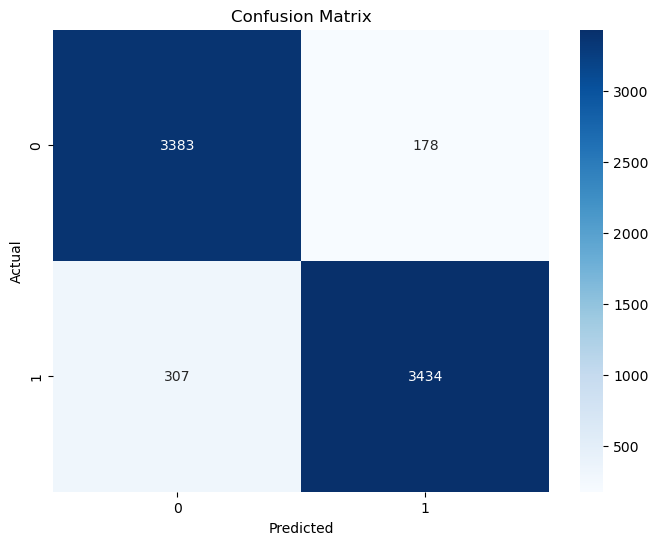

In [222]:
# Evaluate the performance of the model
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [224]:
# Print the formatted classification report
class_report = classification_report(y_test, y_pred)
print("\tClassification Report:\n\n", class_report)

	Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.95      0.93      3561
           1       0.95      0.92      0.93      3741

    accuracy                           0.93      7302
   macro avg       0.93      0.93      0.93      7302
weighted avg       0.93      0.93      0.93      7302

